

Medium correlation:
YearBuilt 0.5228973328794969
YearRemodAdd 0.5071009671113865
MasVnrArea 0.4726144990045743
ExterQual 0.68263924165626
BsmtQual 0.5852071991725198
TotalBsmtSF 0.6135805515591954
HeatingQC 0.42764870739880384
1stFlrSF 0.6058521846919148
FullBath 0.5606637627484456
KitchenQual 0.6595997207286632
TotRmsAbvGrd 0.5337231555820284
Fireplaces 0.4669288367515277
FireplaceQu 0.5204376059504018
GarageFinish 0.5492467563332121
GarageCars 0.6404091972583531
GarageArea 0.6234314389183617
Neighborhood_NridgHt 0.40214859817526727
Foundation_PConc 0.49773375258693675


High correlation:
OverallQual 0.7909816005838047
GrLivArea 0.7086244776126522
0.9595151831720452
17454.534285430687





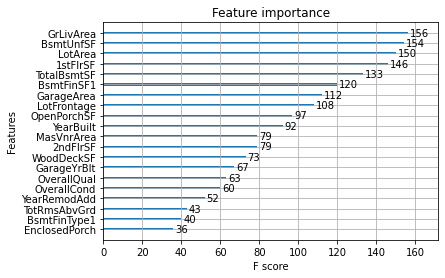

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

training_filename = "/Users/fawzankhan/Desktop/house-prices-advanced-regression-techniques/train.csv"
testing_filename = "/Users/fawzankhan/Desktop/house-prices-advanced-regression-techniques/test.csv"

training_dataset = pd.read_csv(training_filename)
testing_dataset = pd.read_csv(testing_filename)

#plt.figure(figsize=(20, 20))
#sns.heatmap(training_dataset.corr(), cmap='rocket', annot=True, fmt=f'0.1', cbar=False);

# Handle Ordinal Categorial Features 

# Find out which features are more than 80% empty 
'''
nullVal = pd.DataFrame({'Amount': training_dataset.isnull().sum(),
              'Percent': (training_dataset.isnull().sum() / len(training_dataset)) *100}).sort_values(by='Percent', ascending=False)
print(nullVal)

print()

nullValTest = pd.DataFrame({'Amount': testing_dataset.isnull().sum(),
              'Percent': (testing_dataset.isnull().sum() / len(testing_dataset)) *100}).sort_values(by='Percent', ascending=False)
print(nullValTest)'''

training_dataset.pop('MiscFeature')
training_dataset.pop('MoSold')
training_dataset.pop('YrSold')

testing_dataset.pop('MiscFeature')
testing_dataset.pop('MoSold')
testing_dataset.pop('YrSold')

#for elem in list(training_dataset.select_dtypes(exclude=['object']).columns):
    #print(training_dataset.plot.scatter(x='SalePrice', y=elem, c='DarkBlue'))

ordinal_feature_list1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                         'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_feature1_mapping = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
for i in range(len(ordinal_feature_list1)):
    training_dataset[ordinal_feature_list1[i]] = training_dataset[ordinal_feature_list1[i]].map(ordinal_feature1_mapping)
    testing_dataset[ordinal_feature_list1[i]] = testing_dataset[ordinal_feature_list1[i]].map(ordinal_feature1_mapping)
    
ordinal_feature2_mapping = {'No':1, 'Mn':2, 'Av':3, 'Gd':4}
training_dataset['BsmtExposure'] = training_dataset['BsmtExposure'].map(ordinal_feature2_mapping)
testing_dataset['BsmtExposure'] = testing_dataset['BsmtExposure'].map(ordinal_feature2_mapping)

ordinal_feature3_mapping = {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
training_dataset['BsmtFinType1'] = training_dataset['BsmtFinType1'].map(ordinal_feature3_mapping)
training_dataset['BsmtFinType2'] = training_dataset['BsmtFinType2'].map(ordinal_feature3_mapping)
testing_dataset['BsmtFinType1'] = testing_dataset['BsmtFinType1'].map(ordinal_feature3_mapping)
testing_dataset['BsmtFinType2'] = testing_dataset['BsmtFinType2'].map(ordinal_feature3_mapping)

ordinal_feature4_mapping = {'Unf':1, 'RFn':2, 'Fin':3}
training_dataset['GarageFinish'] = training_dataset['GarageFinish'].map(ordinal_feature4_mapping)
testing_dataset['GarageFinish'] = testing_dataset['GarageFinish'].map(ordinal_feature4_mapping)

ordinal_feature5_mapping = {'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
training_dataset['Fence'] = training_dataset['Fence'].map(ordinal_feature5_mapping)
testing_dataset['Fence'] = testing_dataset['Fence'].map(ordinal_feature5_mapping)

############
'''
training_dataset['LotFrontage'] = training_dataset['LotFrontage'].fillna(training_dataset['LotFrontage'].median())
testing_dataset['LotFrontage'] = testing_dataset['LotFrontage'].fillna(testing_dataset['LotFrontage'].median())

for i in range(1460):
    if np.isnan(training_dataset.loc[i,'GarageYrBlt']):
        training_dataset.loc[i, 'GarageYrBlt'] = training_dataset.loc[i, 'YearBuilt']
        
for i in range(1459):
    if np.isnan(testing_dataset.loc[i,'GarageYrBlt']):
        testing_dataset.loc[i, 'GarageYrBlt'] = testing_dataset.loc[i, 'YearBuilt']
'''

# Handle Nominal Categorial Features
training_dataset = training_dataset.fillna(0)
testing_dataset = testing_dataset.fillna(0)

train_col_list = list(training_dataset.select_dtypes(include=['object']).columns)
test_col_list = list(testing_dataset.select_dtypes(include=['object']).columns)

for i in range(len(train_col_list)):
    training_dataset = pd.get_dummies(training_dataset, columns=[train_col_list[i]])
    
for j in range(len(test_col_list)):
     testing_dataset = pd.get_dummies(testing_dataset, columns=[test_col_list[j]])
        
# Check for outlying features

Ids = training_dataset.pop('Id')
testIds = testing_dataset.pop('Id')

trainCol = set(training_dataset.columns)
testCol = set(testing_dataset.columns)
trainCol.remove('SalePrice')

# Outlying features in training set that are not in testing 
trainList = list(trainCol - testCol)
# Outlying features in testing set that are not in training 
testList = list(testCol - trainCol)

'''
for i in range(len(trainList)):
    # Get the correlation of that feature with SalePrice to see if there is any significant relationship
    print(training_dataset[trainList[i]].corr(training_dataset['SalePrice']), "\n")
    # Check how spread the values for the feature are
    print(training_dataset[trainList[i]].value_counts(), "\n")
    print(training_dataset[trainList[i]].describe(), "\n")

print("\n\n\n\nTesting\n")

for i in range(len(testList)):
    # Check how spread the valyes for the feature are
    print(testing_dataset[testList[i]].value_counts())
    print(testing_dataset[testList[i]].describe())
'''
    
# Since all the features have very weak correlations to SalePrice and their value_counts indicate in every feature
# there are at most less than 10/1460 that have different values than the rest. This is enough to indicate these 
# features are outlying features and can be excluded from the model.

# Drop the outlying features
for i in range(len(trainList)):
    training_dataset.pop(trainList[i])
    
for i in range(len(testList)):
    testing_dataset.pop(testList[i])
    
salePrice = training_dataset.pop('SalePrice')

    
# More Data Preprocessing   


mincorrList = {}
smallCorrList = {}
medCorrList = {}
highCorrList = {}

for elem in training_dataset.columns:
    if abs(training_dataset[elem].corr(salePrice)) < 0.1:
        mincorrList[elem] = training_dataset[elem].corr(salePrice)
    elif abs(training_dataset[elem].corr(salePrice)) >= 0.1 and abs(training_dataset[elem].corr(salePrice)) <= 0.4:
        smallCorrList[elem] = training_dataset[elem].corr(salePrice)
    elif abs(training_dataset[elem].corr(salePrice)) > 0.4 and abs(training_dataset[elem].corr(salePrice)) <= 0.7:
        medCorrList[elem] = training_dataset[elem].corr(salePrice)
    elif abs(training_dataset[elem].corr(salePrice)) > 0.7 and abs(training_dataset[elem].corr(salePrice)) <= 1.0:
        highCorrList[elem] = training_dataset[elem].corr(salePrice)

'''
#print("Little to no correlation:")
#for x,y in mincorrList.items():
    #print(x)
    #print(x,y)
    #print("Length =", len(mincorrList))
    
print("\n\nSmall correlation:")
for x,y in smallCorrList.items():
    print(x,y)
    print("Length =", len(smallCorrList))

print("\n\nMedium correlation:")
for x,y in medCorrList.items():
    print(x,y)
    print("Length =", len(medCorrList))
    
print("\n\nHigh correlation:")
for x,y in highCorrList.items():
    print(x,y)
    print("Length =", len(highCorrList))'''
    
'''lowCorrToRemove = mincorrList.keys()
for elem in lowCorrToRemove:
    training_dataset.pop(elem)
    testing_dataset.pop(elem)'''
########### Train and Predict ###########

train, test, trainSalePrice, testSalePrice = train_test_split(training_dataset, salePrice, test_size=0.1, random_state=1)

# XGB Model
xgbModel = xgb.XGBRegressor(min_child_weight=3, learning_rate=0.1, colsample_bytree=0.2, subsample=0.7, n_estimators=500, reg_lambda=2, reg_alpha=0.5, max_depth=3, gamma=1, random_state=1)
xgbModel = xgbModel.fit(train, trainSalePrice)
predicted = xgbModel.predict(test)
print(r2_score(testSalePrice, predicted))
print(mean_squared_error(testSalePrice, predicted, squared=False))
xgb.plot_importance(xgbModel, max_num_features=20, importance_type='weight')


#testxgbPred = xgbModel.predict(testing_dataset)
#xgboutput = pd.DataFrame({'Id':testIds,
                          #'SalePrice':testxgbPred})
#xgboutput.to_csv('submission.csv', index=False)
print()

# Random Forest Model
#rfModel = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=1)
#rfModel = rfModel.fit(train, trainSalePrice)
#rfPredicted = rfModel.predict(test)
#print(r2_score(testSalePrice, rfPredicted))
#print(mean_squared_error(testSalePrice, rfPredicted, squared=False))
'''testRFPred = rfModel.predict(testing_dataset)
rfoutput = pd.DataFrame({'Id':testIds,
                          'SalePrice':testRFPred})
rfoutput.to_csv('submission.csv', index=False)'''
print()

# Gradient Boosting Model
#gbModel = GradientBoostingRegressor(loss='huber', learning_rate=0.1, n_estimators=500, max_depth=3, alpha=0.8, random_state=1)
#gbModel = gbModel.fit(train, trainSalePrice)
#gbPredicted = gbModel.predict(test)
#print(r2_score(testSalePrice, gbPredicted))
#print(mean_squared_error(testSalePrice, gbPredicted, squared=False))
'''testgbPred = gbModel.predict(testing_dataset)
gboutput = pd.DataFrame({'Id':testIds,
                          'SalePrice':testgbPred})
gboutput.to_csv('submission.csv', index=False)'''
print()

# LGB Model
#lgbModel = lgb.LGBMRegressor(max_depth=3, learning_rate=0.1, n_estimators=1000, subsample_for_bin=600, colsample_bytree=0.5, reg_alpha=0.5, random_state=1)
#lgbModel = lgbModel.fit(train, trainSalePrice)
#lgbPredicted = lgbModel.predict(test)
#print(r2_score(testSalePrice, lgbPredicted))
#print(mean_squared_error(testSalePrice, lgbPredicted, squared=False))
#testlgbPred = lgbModel.predict(testing_dataset)
#lgboutput = pd.DataFrame({'Id':testIds,
                          #'SalePrice':testlgbPred})
#lgboutput.to_csv('submission.csv', index=False)